Train shape: (122, 17)  Test shape: (432, 17)
Train label counts: [62 60]

HP units=2, act=tanh, lr=0.001, mom=0.5, l2=0.1 -> mean best val_acc=0.7937
HP units=2, act=tanh, lr=0.001, mom=0.5, l2=0.2 -> mean best val_acc=0.8187
HP units=2, act=tanh, lr=0.001, mom=0.5, l2=0.5 -> mean best val_acc=0.7291
HP units=2, act=tanh, lr=0.001, mom=0.7, l2=0.1 -> mean best val_acc=0.8681
HP units=2, act=tanh, lr=0.001, mom=0.7, l2=0.2 -> mean best val_acc=0.8435
HP units=2, act=tanh, lr=0.001, mom=0.7, l2=0.5 -> mean best val_acc=0.7535
HP units=2, act=tanh, lr=0.001, mom=0.9, l2=0.1 -> mean best val_acc=0.9260
HP units=2, act=tanh, lr=0.001, mom=0.9, l2=0.2 -> mean best val_acc=0.9179
HP units=2, act=tanh, lr=0.001, mom=0.9, l2=0.5 -> mean best val_acc=0.8435
HP units=2, act=tanh, lr=0.01, mom=0.5, l2=0.1 -> mean best val_acc=0.9341
HP units=2, act=tanh, lr=0.01, mom=0.5, l2=0.2 -> mean best val_acc=0.9260
HP units=2, act=tanh, lr=0.01, mom=0.5, l2=0.5 -> mean best val_acc=0.8933
HP units=2, act=

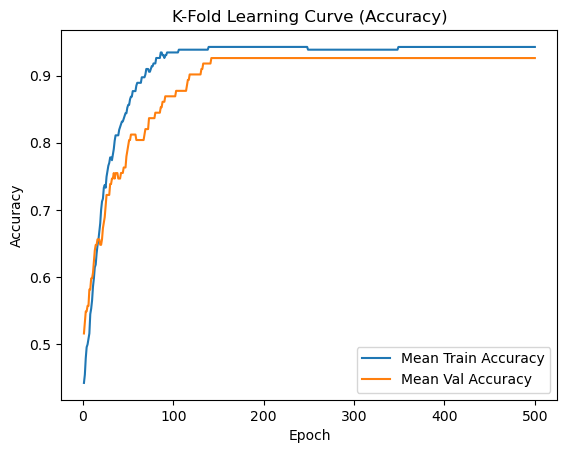

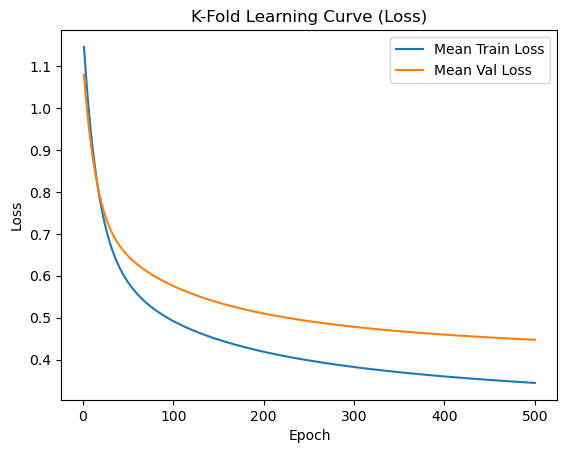

c:\Users\hiend\miniconda3\envs\corso\lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)



Final Train accuracy: 0.9344, Train loss: 0.3401

Final Test accuracy: 0.9722, Test loss: 0.3011
Best hyperparameters: {'units': 2, 'activation': 'tanh', 'learning_rate': 0.01, 'momentum': 0.5, 'l2_strength': 0.1}


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import product
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers


# ----------------------------
# 1) Load + one-hot encode
# ----------------------------
def load_and_preprocess_monk_local(monk_id, data_dir="."):
    train_path = os.path.join(data_dir, f"monks-{monk_id}.train")
    test_path  = os.path.join(data_dir, f"monks-{monk_id}.test")

    columns = ["label", "a1", "a2", "a3", "a4", "a5", "a6", "id"]

    df_train = pd.read_csv(train_path, sep=r"\s+", names=columns, engine="python")
    df_test  = pd.read_csv(test_path,  sep=r"\s+", names=columns, engine="python")

    X_train_raw = df_train.iloc[:, 1:7].values
    y_train = df_train["label"].values.astype(int)

    X_test_raw = df_test.iloc[:, 1:7].values
    y_test = df_test["label"].values.astype(int)

    encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    encoder.fit(X_train_raw)  # fit ONLY on training raw data

    X_train = encoder.transform(X_train_raw)
    X_test  = encoder.transform(X_test_raw)

    return X_train, y_train, X_test, y_test


# Use your local paths
X_train, y_train, X_test, y_test = load_and_preprocess_monk_local(3)
input_dim = X_train.shape[1]

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Train label counts:", np.bincount(y_train))


# ----------------------------
# 2) Model builder (given HP) + L2 weight decay
# ----------------------------
def build_model_from_hp(input_dim, units, activation, learning_rate, momentum, l2_strength):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(
            units,
            activation=activation,
            kernel_regularizer=regularizers.l2(l2_strength) if l2_strength > 0 else None
        ),
        layers.Dense(1, activation="sigmoid")
    ])
    opt = keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
    return model


# ----------------------------
# 3) K-fold CV grid search
# ----------------------------
SEED = 999
tf.keras.utils.set_random_seed(SEED)

units_grid = [2, 3, 4]
activation_grid = ["tanh", "relu"]
lr_grid = [0.001, 0.01, 0.1]
momentum_grid = [0.5, 0.7, 0.9]
l2_grid = [0.1, 0.2, 0.5]

n_splits = 3
max_epochs = 500
batch_size = 16

stop_early = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20,
    min_delta=1e-4,
    restore_best_weights=True
)

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)


def cv_score_for_hp(units, activation, lr, momentum, l2_strength):
    """Return mean(best val accuracy) across folds for this HP combo."""
    fold_best_vals = []

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train, y_train), start=1):
        tf.keras.backend.clear_session()
        tf.keras.utils.set_random_seed(SEED + fold)

        X_tr, y_tr = X_train[tr_idx], y_train[tr_idx]
        X_va, y_va = X_train[va_idx], y_train[va_idx]

        model = build_model_from_hp(input_dim, units, activation, lr, momentum, l2_strength)

        hist = model.fit(
            X_tr, y_tr,
            validation_data=(X_va, y_va),
            epochs=max_epochs,
            batch_size=batch_size,
            callbacks=[stop_early],
            verbose=0,
            shuffle=True
        ).history

        fold_best_vals.append(np.max(hist["val_accuracy"]))

    return float(np.mean(fold_best_vals))


best = {"score": -1.0, "hp": None}

for units, activation, lr, momentum, l2_strength in product(
    units_grid, activation_grid, lr_grid, momentum_grid, l2_grid
):
    score = cv_score_for_hp(units, activation, lr, momentum, l2_strength)
    print(f"HP units={units}, act={activation}, lr={lr}, mom={momentum}, l2={l2_strength} "
          f"-> mean best val_acc={score:.4f}")

    if score > best["score"]:
        best["score"] = score
        best["hp"] = {
            "units": units,
            "activation": activation,
            "learning_rate": lr,
            "momentum": momentum,
            "l2_strength": l2_strength
        }

print("\nBEST HP:", best["hp"], "with mean best val_acc:", best["score"])


# ----------------------------
# 4) Re-run CV with best HP to get mean learning curves
# ----------------------------
def pad_to_len(arr, L):
    arr = np.asarray(arr, dtype=float)
    if len(arr) >= L:
        return arr[:L]
    return np.concatenate([arr, np.full(L - len(arr), np.nan)])


train_acc_mat = []
val_acc_mat = []
train_loss_mat = []
val_loss_mat = []

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train, y_train), start=1):
    tf.keras.backend.clear_session()
    tf.keras.utils.set_random_seed(SEED + 100 + fold)

    X_tr, y_tr = X_train[tr_idx], y_train[tr_idx]
    X_va, y_va = X_train[va_idx], y_train[va_idx]

    model = build_model_from_hp(
        input_dim=input_dim,
        units=best["hp"]["units"],
        activation=best["hp"]["activation"],
        learning_rate=best["hp"]["learning_rate"],
        momentum=best["hp"]["momentum"],
        l2_strength=best["hp"]["l2_strength"]
    )

    hist = model.fit(
        X_tr, y_tr,
        validation_data=(X_va, y_va),
        epochs=max_epochs,
        batch_size=batch_size,
        callbacks=[stop_early],
        verbose=0,
        shuffle=True
    ).history

    train_acc_mat.append(pad_to_len(hist["accuracy"], max_epochs))
    val_acc_mat.append(pad_to_len(hist["val_accuracy"], max_epochs))
    train_loss_mat.append(pad_to_len(hist["loss"], max_epochs))
    val_loss_mat.append(pad_to_len(hist["val_loss"], max_epochs))

train_acc_mean = np.nanmean(np.vstack(train_acc_mat), axis=0)
val_acc_mean   = np.nanmean(np.vstack(val_acc_mat), axis=0)
train_loss_mean = np.nanmean(np.vstack(train_loss_mat), axis=0)
val_loss_mean   = np.nanmean(np.vstack(val_loss_mat), axis=0)

valid_epochs = np.where(~np.isnan(val_acc_mean))[0]
last_epoch = int(valid_epochs[-1]) + 1 if len(valid_epochs) else max_epochs
epochs = np.arange(1, last_epoch + 1)

plt.figure()
plt.plot(epochs, train_acc_mean[:last_epoch])
plt.plot(epochs, val_acc_mean[:last_epoch])
plt.title("K-Fold Learning Curve (Accuracy)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Mean Train Accuracy", "Mean Val Accuracy"])
plt.show()

plt.figure()
plt.plot(epochs, train_loss_mean[:last_epoch])
plt.plot(epochs, val_loss_mean[:last_epoch])
plt.title("K-Fold Learning Curve (Loss)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Mean Train Loss", "Mean Val Loss"])
plt.show()


# ----------------------------
# 5) Train on full training set with best HP, evaluate on test
# ----------------------------
tf.keras.backend.clear_session()
tf.keras.utils.set_random_seed(SEED)

final_model = build_model_from_hp(
    input_dim=input_dim,
    units=best["hp"]["units"],
    activation=best["hp"]["activation"],
    learning_rate=best["hp"]["learning_rate"],
    momentum=best["hp"]["momentum"],
    l2_strength=best["hp"]["l2_strength"]
)

final_model.fit(
    X_train, y_train,
    epochs=max_epochs,
    batch_size=batch_size,
    callbacks=[stop_early],
    verbose=0,
    shuffle=True
)
train_loss, train_acc = final_model.evaluate(X_train, y_train, verbose=0)
print(f"\nFinal Train accuracy: {train_acc:.4f}, Train loss: {train_loss:.4f}")

test_loss, test_acc = final_model.evaluate(X_test, y_test, verbose=0)
print(f"\nFinal Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")
print("Best hyperparameters:", best["hp"])
